# Access Database-Files to explore and summerise Data

In [194]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [195]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [294]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-03-21/data_eval_new/"
file_name = "int_norm_20170321_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [295]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [296]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [297]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

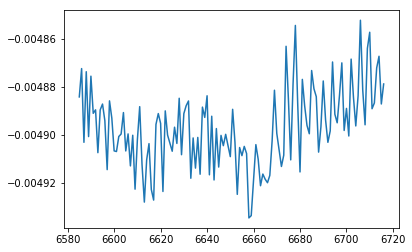

In [298]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

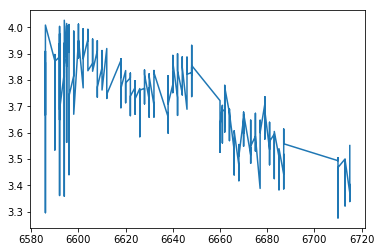

In [299]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

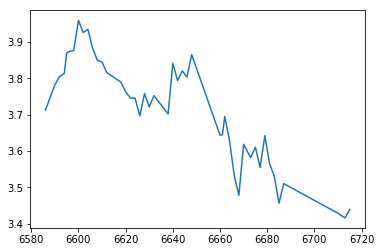

In [300]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

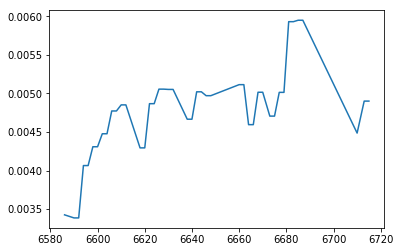

In [301]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [302]:
background_mean = df_mean(background)

# Outlier rejection

In [364]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [365]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [366]:
column = "124/120"
sample = "NIST 200ppb"

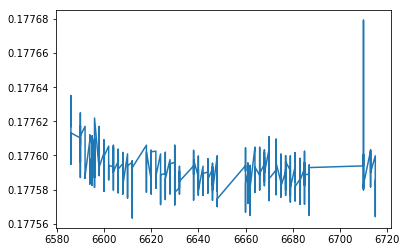

In [367]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [368]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [369]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-03-21 18:05:00,NIST 200ppb,2,1,6586,0.029823,NaN,0.010355,0.445963,0.235323,0.742935,0.263508,0.142117,0.177623
2017-03-21 18:05:00,NIST 200ppb,2,2,6586,0.029819,0.020188,0.010355,0.445956,0.235326,0.742935,0.263509,0.142111,0.177617
2017-03-21 18:05:00,NIST 200ppb,2,3,6586,0.029821,0.020189,0.010356,0.445965,0.235337,0.742935,0.263508,0.142110,0.177618
2017-03-21 18:05:00,NIST 200ppb,2,4,6586,0.029817,0.020187,0.010358,0.445971,0.235323,NaN,0.263521,0.142120,0.177635
2017-03-21 18:05:00,NIST 200ppb,2,5,6586,0.029821,0.020188,0.010359,0.445983,0.235330,NaN,0.263514,0.142113,0.177616
2017-03-21 18:05:00,NIST 200ppb,2,6,6586,0.029820,0.020186,0.010356,0.445976,0.235333,0.742935,0.263500,0.142114,0.177613
2017-03-21 18:05:00,NIST 200ppb,2,7,6586,0.029822,0.020192,0.010358,0.445970,0.235329,0.742935,0.263518,0.142113,0.177617
2017-03-21 18:05:00,NIST 200ppb,2,8,6586,0.029825,0.020192,0.010357,0.445981,0.235335,0.742935,0.263504,0.142106,0.177600
2017-03-21 18:05:00,NIST 200ppb,2,9,6586,0.029817,0.020185,0.010356,0.445958,0.235329,0.742935,0.263496,0.142109,0.177602


In [370]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
6588        2017-03-21 18:31:00    0.187122
6591        2017-03-21 19:11:00    0.187167
            2017-03-21 19:11:00    0.187188
            2017-03-21 19:11:00    0.187190
6595        2017-03-21 20:04:00    0.187161
6596        2017-03-21 20:19:00    0.187155
6598        2017-03-21 20:44:00    0.187242
6608        2017-03-21 23:02:00    0.187297
6612        2017-03-21 23:56:00    0.187260
6643        2017-03-22 06:53:00    0.166561
6648        2017-03-22 08:01:00    0.187289
6654        2017-03-22 09:20:00    0.187387
6656        2017-03-22 09:49:00    0.187328
6683        2017-03-22 16:17:00    0.187426
6690        2017-03-22 17:52:00    0.187543
6703        2017-03-22 20:50:00    0.187456
6710        2017-03-22 22:28:00    0.187533
6715        2017-03-22 23:35:00    0.187497
Name: 124/120, dtype: float64

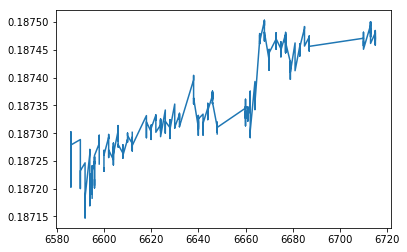

In [371]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [372]:
df[df["Sample"] == sample][column].std()

8.368311118093523e-05

In [373]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

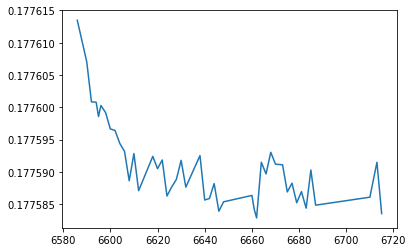

In [374]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [375]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-03-21 18:05:00,6586,NIST 200ppb,0.029820,0.020188,0.010358,0.445978,0.235331,0.742935,0.263508,0.142112,0.177613
2017-03-21 18:31:00,6588,NIST 100ppb,0.029822,0.020190,0.010359,0.445984,0.235330,0.742935,0.263509,0.142110,0.177609
2017-03-21 18:56:00,6590,NIST 200ppb,0.029821,0.020188,0.010360,0.445989,0.235332,0.742935,0.263501,0.142109,0.177607
2017-03-21 19:11:00,6591,NIST 100ppb,0.029824,0.020192,0.010361,0.445990,0.235328,0.742935,0.263502,0.142109,0.177607
2017-03-21 19:25:00,6592,NIST 200ppb,0.029823,0.020189,0.010361,0.445993,0.235331,0.742935,0.263496,0.142107,0.177601
2017-03-21 19:50:00,6594,NIST 200ppb,0.029824,0.020190,0.010361,0.445994,0.235332,0.742935,0.263496,0.142106,0.177601
2017-03-21 20:04:00,6595,NIST 200ppb,0.029824,0.020190,0.010361,0.445993,0.235330,0.742935,0.263493,0.142107,0.177599
2017-03-21 20:19:00,6596,NIST 200ppb,0.029824,0.020191,0.010360,0.445998,0.235332,0.742935,0.263492,0.142108,0.177600
2017-03-21 20:44:00,6598,NIST 200ppb,0.029823,0.020191,0.010361,0.445996,0.235331,0.742935,0.263493,0.142107,0.177599


In [376]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [377]:
drop_sum = []

In [378]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [379]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [380]:
data_mean_int_sum

112/120                      \
                                              mean           SD2 count   
Sample                                                                   
EET92048 bomb 1_2                         0.029831           NaN     1   
GRA06100 bomb 1_2                         0.029829           NaN     1   
Indarch bomb 1_2                          0.029834           NaN     1   
J.W. Leach 3b+c                           0.029832           NaN     1   
NIST 100ppb                               0.029830  5.576552e-06    29   
NIST 200ppb                               0.029830  8.437749e-06    46   
NIST 200ppb + 0.005ppb U                  0.029828           NaN     1   
NIST 200ppb + 0.030ppb Cd                 0.029828           NaN     1   
NIST 200ppb + 0.04ppb Cd                  0.029832           NaN     1   
NIST 200ppb + 0.100ppb Zr                 0.029831           NaN     1   
NIST 200ppb + 0.150ppb Rh                 0.029830           NaN     1   
NIST 200ppb + 0.300ppb Ru                 0.029829           NaN     1   
NIST 200ppb + 0.50ppb Pd                  0.029826           NaN     1   
NIST 200ppb + 0.628ppb Te                 0.035519           NaN     1   
NIST 200ppb + 2ppb Mo                     0.029824           NaN     1   
NIST 200ppb + ME                          0.029832           NaN     1   
NIST 350ppb                               0.029835  6.157898e-07     2   
ZH09-05 23.3_1_7                          0.029832           NaN     1   
ZH09-05 23.3_3b_2 Aliq. 2 100ppb          0.029830           NaN     1   
ZH09-05 23.3_3b_3 Aliq. 2 no-peak-center  0.029832           NaN     1   
ZH09-05 23.3_3b_3 Aliq.2                  0.029836           NaN     1   

                                           114/120                      \
                                              mean           SD2 count   
Sample                                                                   
EET92048 bomb 1_2                         0.020194           NaN     1   
GRA06100 bomb 1_2                         0.020195           NaN     1   
Indarch bomb 1_2                          0.020197           NaN     1   
J.W. Leach 3b+c                           0.020193           NaN     1   
NIST 100ppb                               0.020195  4.599589e-06    29   
NIST 200ppb                               0.020194  5.642902e-06    46   
NIST 200ppb + 0.005ppb U                  0.020193           NaN     1   
NIST 200ppb + 0.030ppb Cd                 0.020196           NaN     1   
NIST 200ppb + 0.04ppb Cd                  0.020198           NaN     1   
NIST 200ppb + 0.100ppb Zr                 0.020195           NaN     1   
NIST 200ppb + 0.150ppb Rh                 0.020194           NaN     1   
NIST 200ppb + 0.300ppb Ru                 0.020193           NaN     1   
NIST 200ppb + 0.50ppb Pd                  0.020193           NaN     1   
NIST 200ppb + 0.628ppb Te                 0.016021           NaN     1   
NIST 200ppb + 2ppb Mo                     0.020190           NaN     1   
NIST 200ppb + ME                          0.020196           NaN     1   
NIST 350ppb                               0.020198  9.894333e-07     2   
ZH09-05 23.3_1_7                          0.020194           NaN     1   
ZH09-05 23.3_3b_2 Aliq. 2 100ppb          0.020195           NaN     1   
ZH09-05 23.3_3b_3 Aliq. 2 no-peak-center  0.020196           NaN     1   
ZH09-05 23.3_3b_3 Aliq.2                  0.020200           NaN     1   

                                           115/120                      \
                                              mean           SD2 count   
Sample                                                                   
EET92048 bomb 1_2                         0.010362           NaN     1   
GRA06100 bomb 1_2                         0.010360           NaN     1   
Indarch bomb 1_2                          0.010362           NaN     1   
J.W. Leach 3b+c                           0.0

In [381]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)

In [382]:
epsilon_int_100

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-03-21 18:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 100ppb
2017-03-21 18:56:00,0.758783,-0.696730,-1.656379,0.081057,0.040941,0.137660,2.220446e-12,-0.165696,0.011947,-0.051816,NIST 200ppb
2017-03-21 19:11:00,-15.149220,-1.039523,-0.350409,0.081545,-0.245803,-0.217399,0.000000e+00,0.068596,0.287516,0.393455,NIST 100ppb
2017-03-22 00:21:00,16.659094,2.086875,1.631186,0.421197,0.428401,0.247689,2.220446e-12,-0.115682,-0.367178,-0.437647,NIST 100ppb
2017-03-22 00:35:00,0.000000,-1.216082,-0.978122,-0.137751,-0.208641,-0.091141,0.000000e+00,-0.107876,0.045941,-0.093924,NIST 100ppb
2017-03-22 00:50:00,-12.831157,-0.603601,-1.089753,0.207573,0.017999,-0.059711,0.000000e+00,0.020646,0.127625,0.222120,NIST 100ppb
2017-03-22 04:51:00,12.829220,1.393430,2.011721,-0.545271,0.023865,0.080399,-1.110223e-12,-0.020786,-0.239363,-0.189033,NIST 100ppb
2017-03-22 05:05:00,0.000000,-0.438390,-0.462170,0.618681,0.108093,0.048161,0.000000e+00,-0.056339,0.131149,0.042079,NIST 100ppb
2017-03-22 05:20:00,-7.528987,0.282631,0.005178,0.281334,-0.030635,-0.006794,-1.110223e-12,0.124688,-0.015388,0.110858,NIST 100ppb


In [383]:

date_list = []

epsilon_int_200 = epsilon_int_200
delta_raw_200 = delta_raw_200
epsilon_int_100 = epsilon_int_100
delta_raw_100 = delta_raw_100

In [384]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [385]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)
epsilon_int_100 = epsilon_process(epsilon_int_100)
delta_raw_100 = epsilon_process(delta_raw_100)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [386]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-03-21 18:31:00,6588,0.605808,1.036085,0.466538,0.017513,-0.085836,-1.110223e-12,0.157416,-0.069892,-0.062953,NIST 100ppb
2017-03-21 19:11:00,6591,0.616204,1.852598,0.099044,-0.021867,-0.145764,0.000000e+00,0.118263,0.063517,0.160380,NIST 100ppb
2017-03-21 19:25:00,6592,0.093259,0.203684,0.218398,0.038152,-0.021205,0.000000e+00,-0.080699,-0.097348,-0.173216,NIST 200ppb
2017-03-21 19:50:00,6594,0.082833,0.146989,0.363575,0.022314,0.028167,0.000000e+00,0.051015,-0.006831,0.060855,NIST 200ppb
2017-03-21 20:04:00,6595,0.164559,-0.098187,0.019237,-0.065580,-0.060951,2.220446e-12,-0.047593,-0.043477,-0.110321,NIST 200ppb
2017-03-21 20:19:00,6596,0.104026,0.094183,-0.455442,0.068842,0.058088,0.000000e+00,-0.024191,0.087795,0.079225,NIST 200ppb
2017-03-21 20:44:00,6598,-0.631043,-0.385581,0.098108,-0.085780,-0.060227,2.220446e-12,0.006457,0.048157,0.039740,NIST 200ppb
2017-03-21 20:59:00,6599,0.096541,-0.980919,0.022843,0.016413,-0.013121,0.000000e+00,-0.055624,-0.045040,-0.026035,NIST 200ppb + 2ppb Mo
2017-03-21 21:13:00,6600,0.572271,0.833284,0.063966,0.040287,0.042459,-3.330669e-12,0.015873,-0.138921,-0.064207,NIST 200ppb


In [387]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_100_sum = np.round(epsilon_int_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_100_sum = np.round(delta_raw_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum.append([epsilon_int_100_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum.append([delta_raw_100_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [388]:
epsilon_sum_all

112/120                114/120  \
                                              mean    SD2 count      mean   
Sample                                                                      
EET92048 bomb 1_2                           -1.212    NaN     1    -1.889   
GRA06100 bomb 1_2                           -2.173    NaN     1    -1.706   
Indarch bomb 1_2                            -0.085    NaN     1     0.241   
NIST 100ppb                                  0.087  1.213     4     0.985   
NIST 200ppb                                  0.031  0.982    35     0.039   
NIST 200ppb + 0.005ppb U                     0.048    NaN     1    -0.701   
NIST 200ppb + 0.030ppb Cd                   -0.080    NaN     1     0.552   
NIST 200ppb + 0.04ppb Cd                     0.522    NaN     1     1.526   
NIST 200ppb + 0.100ppb Zr                    0.160    NaN     1     0.028   
NIST 200ppb + 0.150ppb Rh                    0.414    NaN     1     0.523   
NIST 200ppb + 0.300ppb Ru                    0.234    NaN     1    -0.179   
NIST 200ppb + 0.50ppb Pd                     0.560    NaN     1     0.949   
NIST 200ppb + 0.628ppb Te                 1907.129    NaN     1 -2066.881   
NIST 200ppb + 2ppb Mo                        0.097    NaN     1    -0.981   
NIST 200ppb + ME                             0.922    NaN     1     1.115   
NIST 350ppb                                  0.404  0.356     2     0.614   
ZH09-05 23.3_3b_3 Aliq. 2 no-peak-center    -0.263    NaN     1    -0.154   
ZH09-05 23.3_3b_3 Aliq.2                     1.221    NaN     1     1.757   
J.W. Leach 3b+c                             -0.849    NaN     1    -1.937   
NIST 100ppb                                 -0.162  1.258    18    -0.194   
NIST 200ppb                                  0.256  1.804     3    -0.490   
ZH09-05 23.3_1_7                             0.297    NaN     1     0.536   
ZH09-05 23.3_3b_2 Aliq. 2 100ppb             0.256    NaN     1     0.654   

                                                        115/120               \
                                            SD2 count      mean    SD2 count   
Sample                                                                         
EET92048 bomb 1_2                           NaN     1    -0.134    NaN     1   
GRA06100 bomb 1_2                           NaN     1    -2.362    NaN     1   
Indarch bomb 1_2                            NaN     1    -1.015    NaN     1   
NIST 100ppb                               1.261     4     0.108  0.656     4   
NIST 200ppb                               1.135    35     0.036  1.160    35   
NIST 200ppb + 0.005ppb U                    NaN     1     0.517    NaN     1   
NIST 200ppb + 0.030ppb Cd                   NaN     1     0.737    NaN     1   
NIST 200ppb + 0.04ppb Cd                    NaN     1     0.283    NaN     1   
NIST 200ppb + 0.100ppb Zr                   NaN     1    -0.121    NaN     1   
NIST 200ppb + 0.150ppb Rh                   NaN     1    -0.085    NaN     1   
NIST 200ppb + 0.300ppb Ru                   NaN     1     0.098    NaN     1   
NIST 200ppb + 0.50ppb Pd                    NaN     1     0.035    NaN     1   
NIST 200ppb + 0.628ppb Te                   NaN     1  5684.132    NaN     1   
NIST 200ppb + 2ppb Mo                       NaN     1     0.023    NaN     1   
NIST 200ppb + ME                            NaN     1    -0.129    NaN     1   
NIST 350ppb                               0.298     2     0.073  0.871     2   
ZH09-05 23.3_3b_3 Aliq. 2 no-peak-center    NaN     1    -0.158    NaN     1   
ZH09-05 23.3_3b_3 Aliq.2                    NaN     1    -2.188    NaN     1   
J.W. Leach 3b+c                             NaN     1    -1.611    NaN     1   
NIST 100ppb                               2.856    18    -0.012  1.778    18   
NIST 200ppb                               2.064     3     0.100  0.522     3   
ZH09-05 23.3_1_7                            NaN     1    -2.083    NaN     1   
ZH09-05 23.3_3b_2 Aliq. 2 100ppb        

In [389]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200.append([epsilon_int_100], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200.append([delta_raw_100], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

SyntaxError: invalid syntax (<ipython-input-389-63deb1ab0e3d>, line 6)

In [260]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [160]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [161]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [390]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_old.xlsx', engine='xlsxwriter')


In [391]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.append([epsilon_int_100]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.append([delta_raw_100]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [392]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [393]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')